# Solver Run Time Comparison
***
## Setup the Environment
***

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../../GillesPy2/')))

MatPlotLib is used for creating custom visualizations

In [2]:
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
import gillespy2

***
## Create the Simple Hybrid Model
***

In [5]:
def create_birth_death_model( initial_value=1 ):
    # Initialize Model
    model = gillespy2.Model(name="Birth-Death")

    # Define Variables (GillesPy2.Species)
    A = gillespy2.Species(name='A', initial_value = initial_value )
    V = gillespy2.Species(name='V', initial_value = initial_value ) # used as a constant scaling factor

    # Add Variables to Model
    model.add_species([A, V])

    # Define Parameters
    rate1 = gillespy2.Parameter(name='rate1', expression= 10.0)
    rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
    
    # Add Parameters to Model
    model.add_parameter([rate1, rate2])

    # Define Reactions
    r1 = gillespy2.Reaction(name="r1", reactants={}, products={'A': 1}, propensity_function="rate1 * V")
    r2 = gillespy2.Reaction(name="r2", reactants={'A': 1}, products={}, rate='rate2')

    # Add Reactions to Model
    model.add_reaction([r1, r2])
    
    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=100, num_points=101)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

***
## Run the Simulations
***
### Time Comparison Test Method

In [6]:
all_solvers = {}
for s in dir(gillespy2.solvers):
    if s.endswith('Solver'):
        #print(s)
        all_solvers[s]=eval('gillespy2.solvers.'+s)
all_solvers

{'CLESolver': gillespy2.solvers.numpy.CLE_solver.CLESolver,
 'NumPySSASolver': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODECSolver': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'ODESolver': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'SSACSolver': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybridCSolver': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauHybridSolver': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeapingCSolver': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver,
 'TauLeapingSolver': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver,
 'VariableSSACSolver': gillespy2.solvers.cpp.variable_ssa_c_solver.VariableSSACSolver}

In [7]:
Solver_plot_order = ['SSA','TauHybrid','TauLeaping','ODE']

In [8]:
C_solvers = {
 'ODE': gillespy2.solvers.cpp.ode_c_solver.ODECSolver,
 'SSA': gillespy2.solvers.cpp.ssa_c_solver.SSACSolver,
 'TauHybrid': gillespy2.solvers.cpp.tau_hybrid_c_solver.TauHybridCSolver,
 'TauLeaping': gillespy2.solvers.cpp.tau_leaping_c_solver.TauLeapingCSolver}

In [9]:
NumPy_solvers = {
 'SSA': gillespy2.solvers.numpy.ssa_solver.NumPySSASolver,
 'ODE': gillespy2.solvers.numpy.ode_solver.ODESolver,
 'TauHybrid': gillespy2.solvers.numpy.tau_hybrid_solver.TauHybridSolver,
 'TauLeaping': gillespy2.solvers.numpy.tau_leaping_solver.TauLeapingSolver
}

In [10]:
def run_test(solverClass, max_time=0.5):
    import inspect
    if 'variable' in inspect.signature(solverClass).parameters.keys():
        model = create_birth_death_model()
        solver = solverClass(model=model, variable=True)
        run_times = []
        for val in v_range:
            time_start = time.perf_counter()
            model.run(solver=solver, variables={"V": val,"A": val})
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
    else:
        run_times = []
        for val in v_range:
            model = create_birth_death_model(val)
            solver = solverClass(model=model)
            time_start = time.perf_counter()
            model.run(solver=solver)
            time_end = time.perf_counter()
            run_times.append(time_end - time_start)
            if (time_end - time_start) > max_time:
                break
        return run_times
        

In [11]:
def run_all_test(solver_list, max_time=0.5):
    timing_data = {}
    for name,solver in solver_list.items():
        print(name, end=' ')
        try:
            time_start = time.perf_counter()
            timing_data[name] = run_test(solver, max_time=max_time)
            time_end = time.perf_counter()
            print(len(timing_data[name]), end=' ')
            print(str(time_end - time_start)+'s')
        except Exception as e:
            print("Caught: "+str(e))
    return timing_data

# C++ Solvers

In [12]:
v_range = range(1, 3000, 20)

In [13]:
%time C_solver_timing_data = run_all_test(C_solvers)

ODE 150 10.97296128400194s
SSA 150 31.065549208000448s
TauHybrid 150 32.532477814998856s
TauLeaping 150 12.460571411000274s
CPU times: user 1.12 s, sys: 1.45 s, total: 2.56 s
Wall time: 1min 27s


In [14]:
C_solver_timing_data

{'ODE': [0.009995890999562107,
  0.007899812000687234,
  0.00857275400267099,
  0.008154721002938459,
  0.00994362300116336,
  0.008121154001855757,
  0.008528873000614112,
  0.008144515999447322,
  0.009626731000025757,
  0.008850669000821654,
  0.00891795700226794,
  0.009538581998640439,
  0.008742632999201305,
  0.00880428100208519,
  0.008145651998347603,
  0.009157974000117974,
  0.008048823001445271,
  0.008954175998951541,
  0.008034831000259146,
  0.009289194000302814,
  0.008054259000346065,
  0.00855851099913707,
  0.008005178002349567,
  0.009154414998192806,
  0.007904306999989785,
  0.008525655000994448,
  0.007838742996682413,
  0.00889680999898701,
  0.00799477300097351,
  0.008598329997766996,
  0.007241568000608822,
  0.009180261000437895,
  0.007956569999805652,
  0.010675269000785192,
  0.008860488000209443,
  0.008276344000478275,
  0.008253126998170046,
  0.008276624001155142,
  0.00780063400088693,
  0.009103723001317121,
  0.008438955999736208,
  0.0080014859995

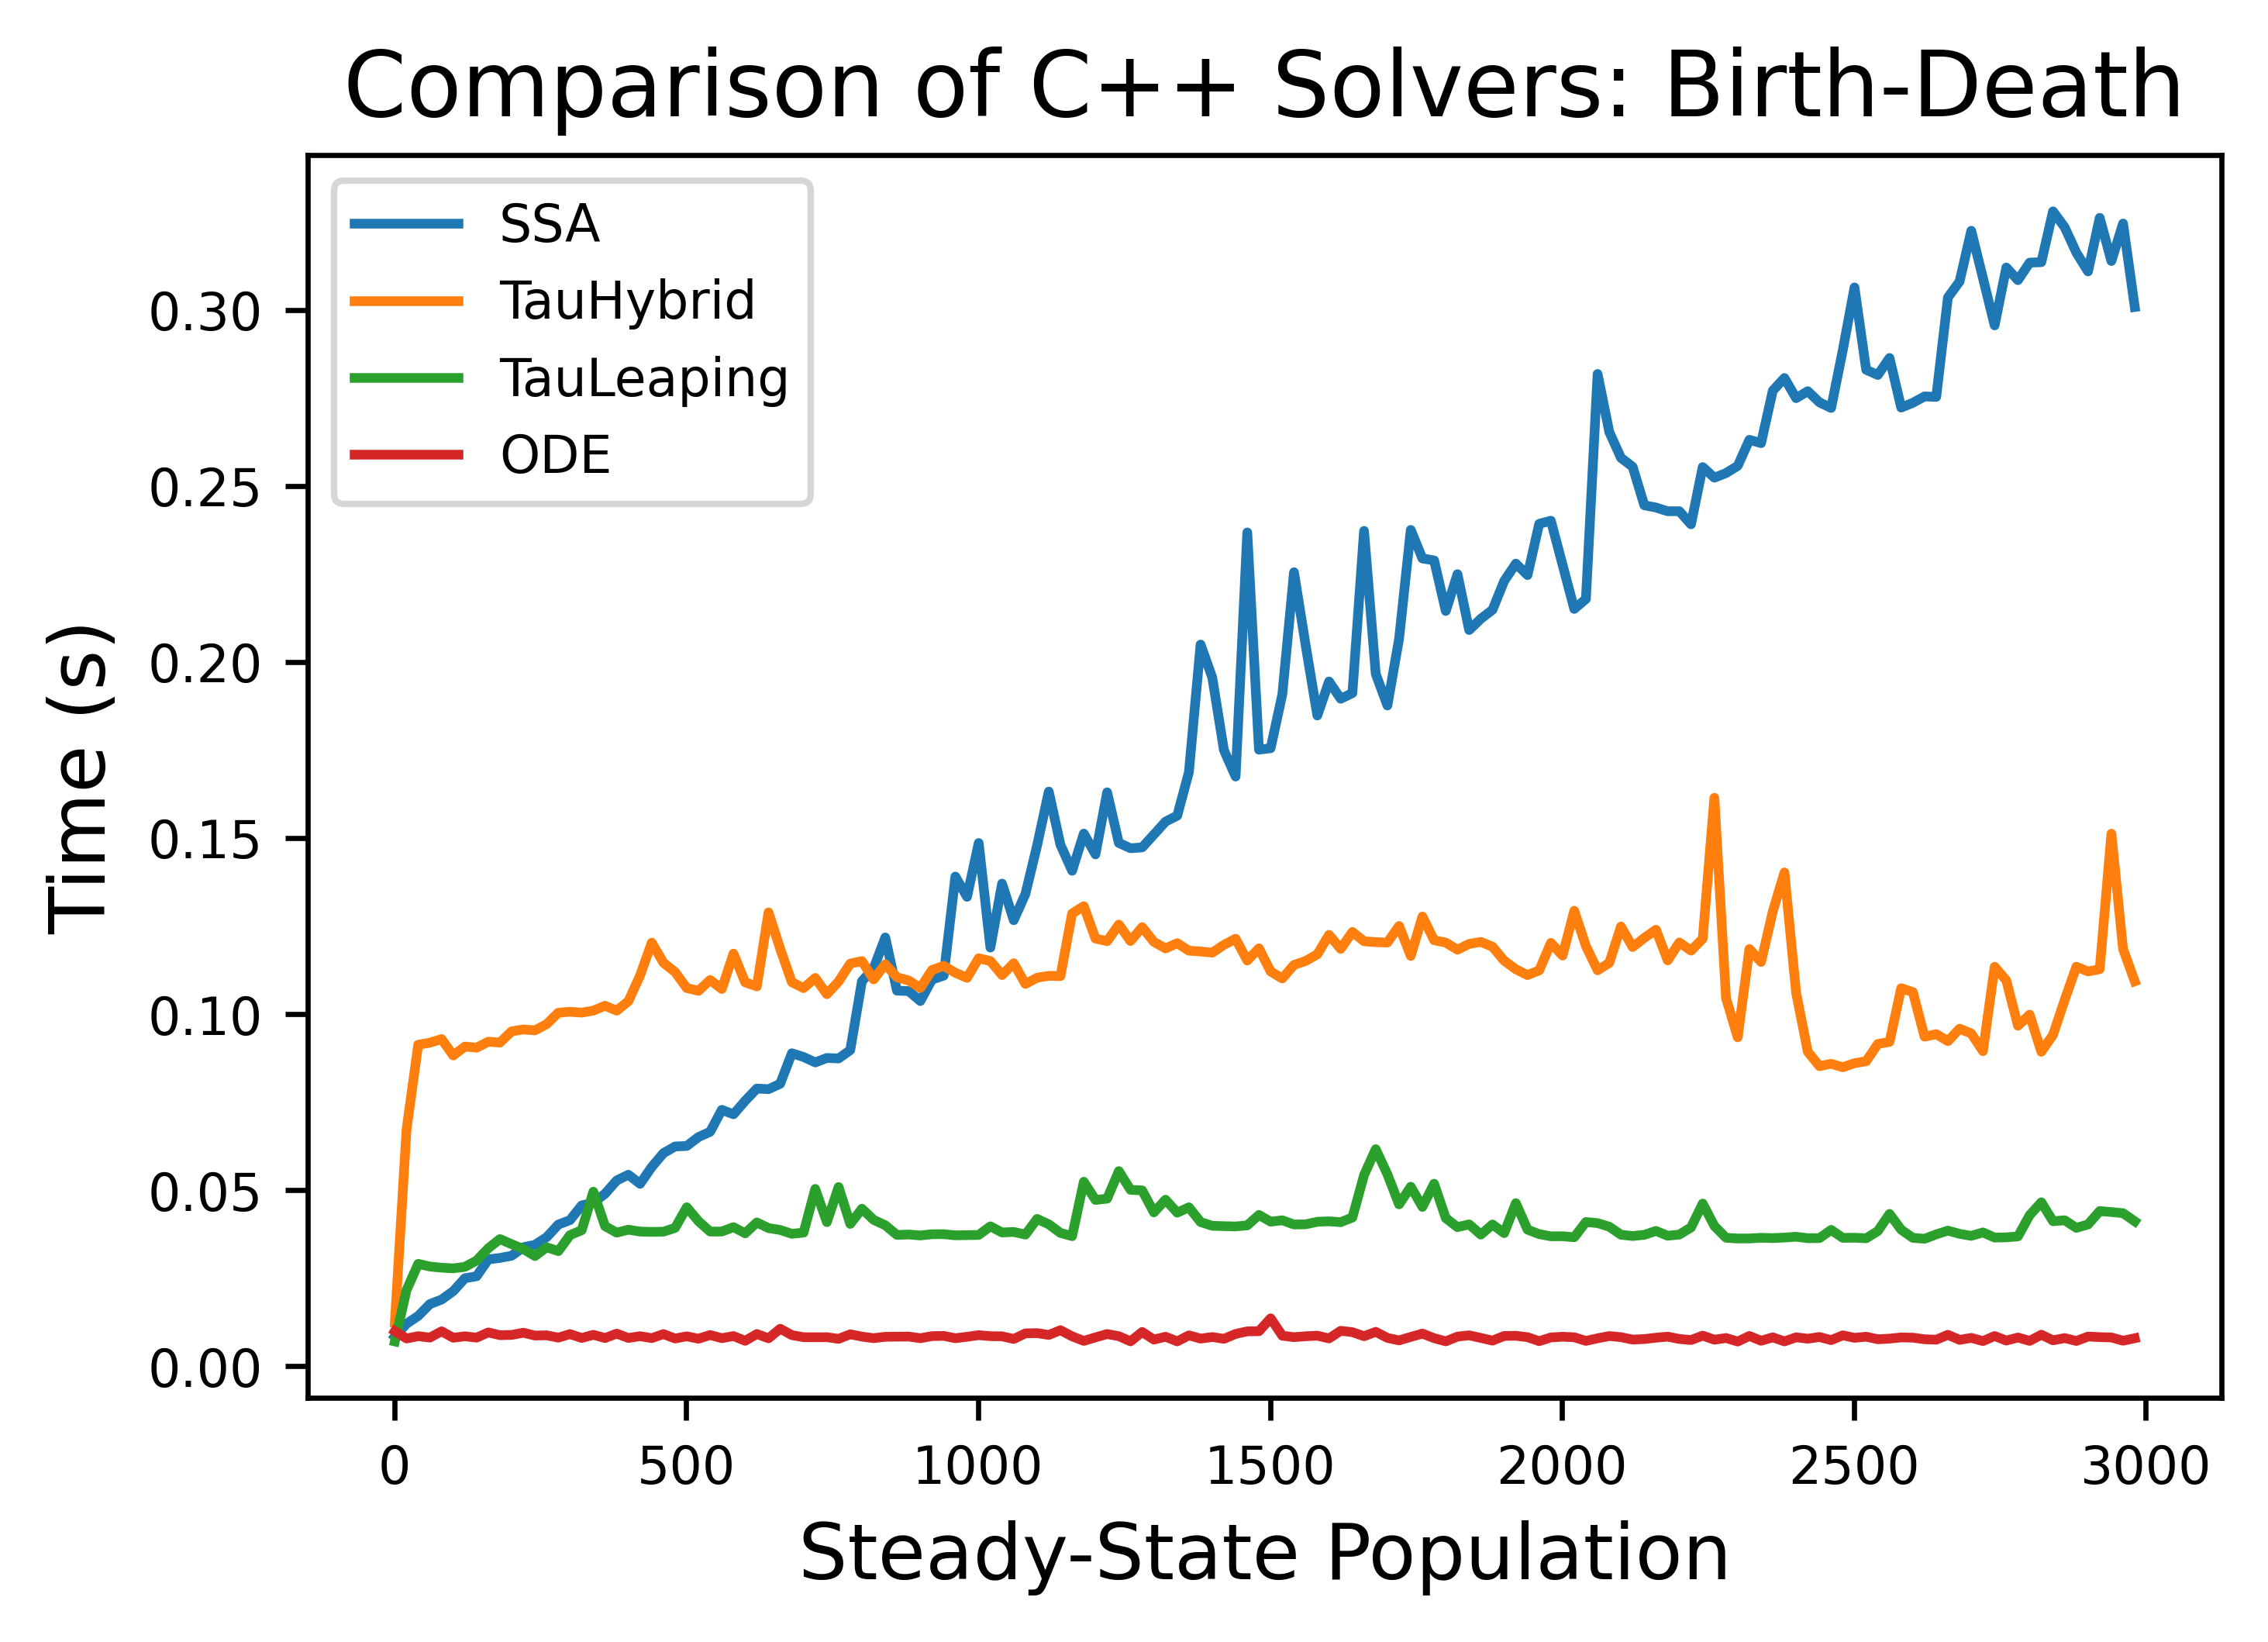

In [15]:
#fig = plt.figure(figsize=(3.54,3.54), dpi=600)
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
#for name,times in C_solver_timing_data.items():
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    try:
        plt.plot(v_range[0:len(C_solver_timing_data[name])], C_solver_timing_data[name], label=name2)
    except Exception as e:
        print(name)
        raise e
plt.title("Comparison of C++ Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Solvers.pdf', bbox_inches='tight')

# Numpy Solvers

In [16]:
v_range = range(1, 50, 1)

In [17]:
%time NumPy_solvers_timing_data = run_all_test(NumPy_solvers, max_time=4)

SSA 49 28.50921160800135s
ODE 49 0.13312723000126425s
TauHybrid 12 27.999275211001077s
TauLeaping 49 16.39393049100181s
CPU times: user 1min 13s, sys: 290 ms, total: 1min 13s
Wall time: 1min 13s


In [18]:
NumPy_solvers_timing_data.items()

dict_items([('SSA', [0.027962527001363924, 0.04156154299926129, 0.052365604002261534, 0.07070965499951853, 0.11074532299971906, 0.13396872299927054, 0.16809194500092417, 0.19676014699871303, 0.17353356199964765, 0.20481754800130147, 0.2647629649982264, 0.2907752389983216, 0.3725851839990355, 0.358109182001499, 0.2988811319992237, 0.3380868719978025, 0.41174401200260036, 0.36959063099857303, 0.3867124470016279, 0.4037218199991912, 0.4502834619997884, 0.43772902800265, 0.4735997059979127, 0.4655303929976071, 0.4861466120019031, 0.5321878559989273, 0.5043422599992482, 0.5362730639972142, 0.5505174770005397, 0.6854553789999045, 0.5954740689994651, 0.8296446679996734, 0.709430462000455, 0.8145389589990373, 0.9245172619994264, 1.1812872199989215, 0.997272560998681, 0.8048963360015478, 0.9499887910023972, 1.0824126439983957, 0.9359898379989318, 0.8277147069966304, 0.9039072489977116, 1.0115051990032953, 1.1005614239984425, 1.0817797709969454, 1.2718406789972505, 1.3549763150003855, 1.29112409

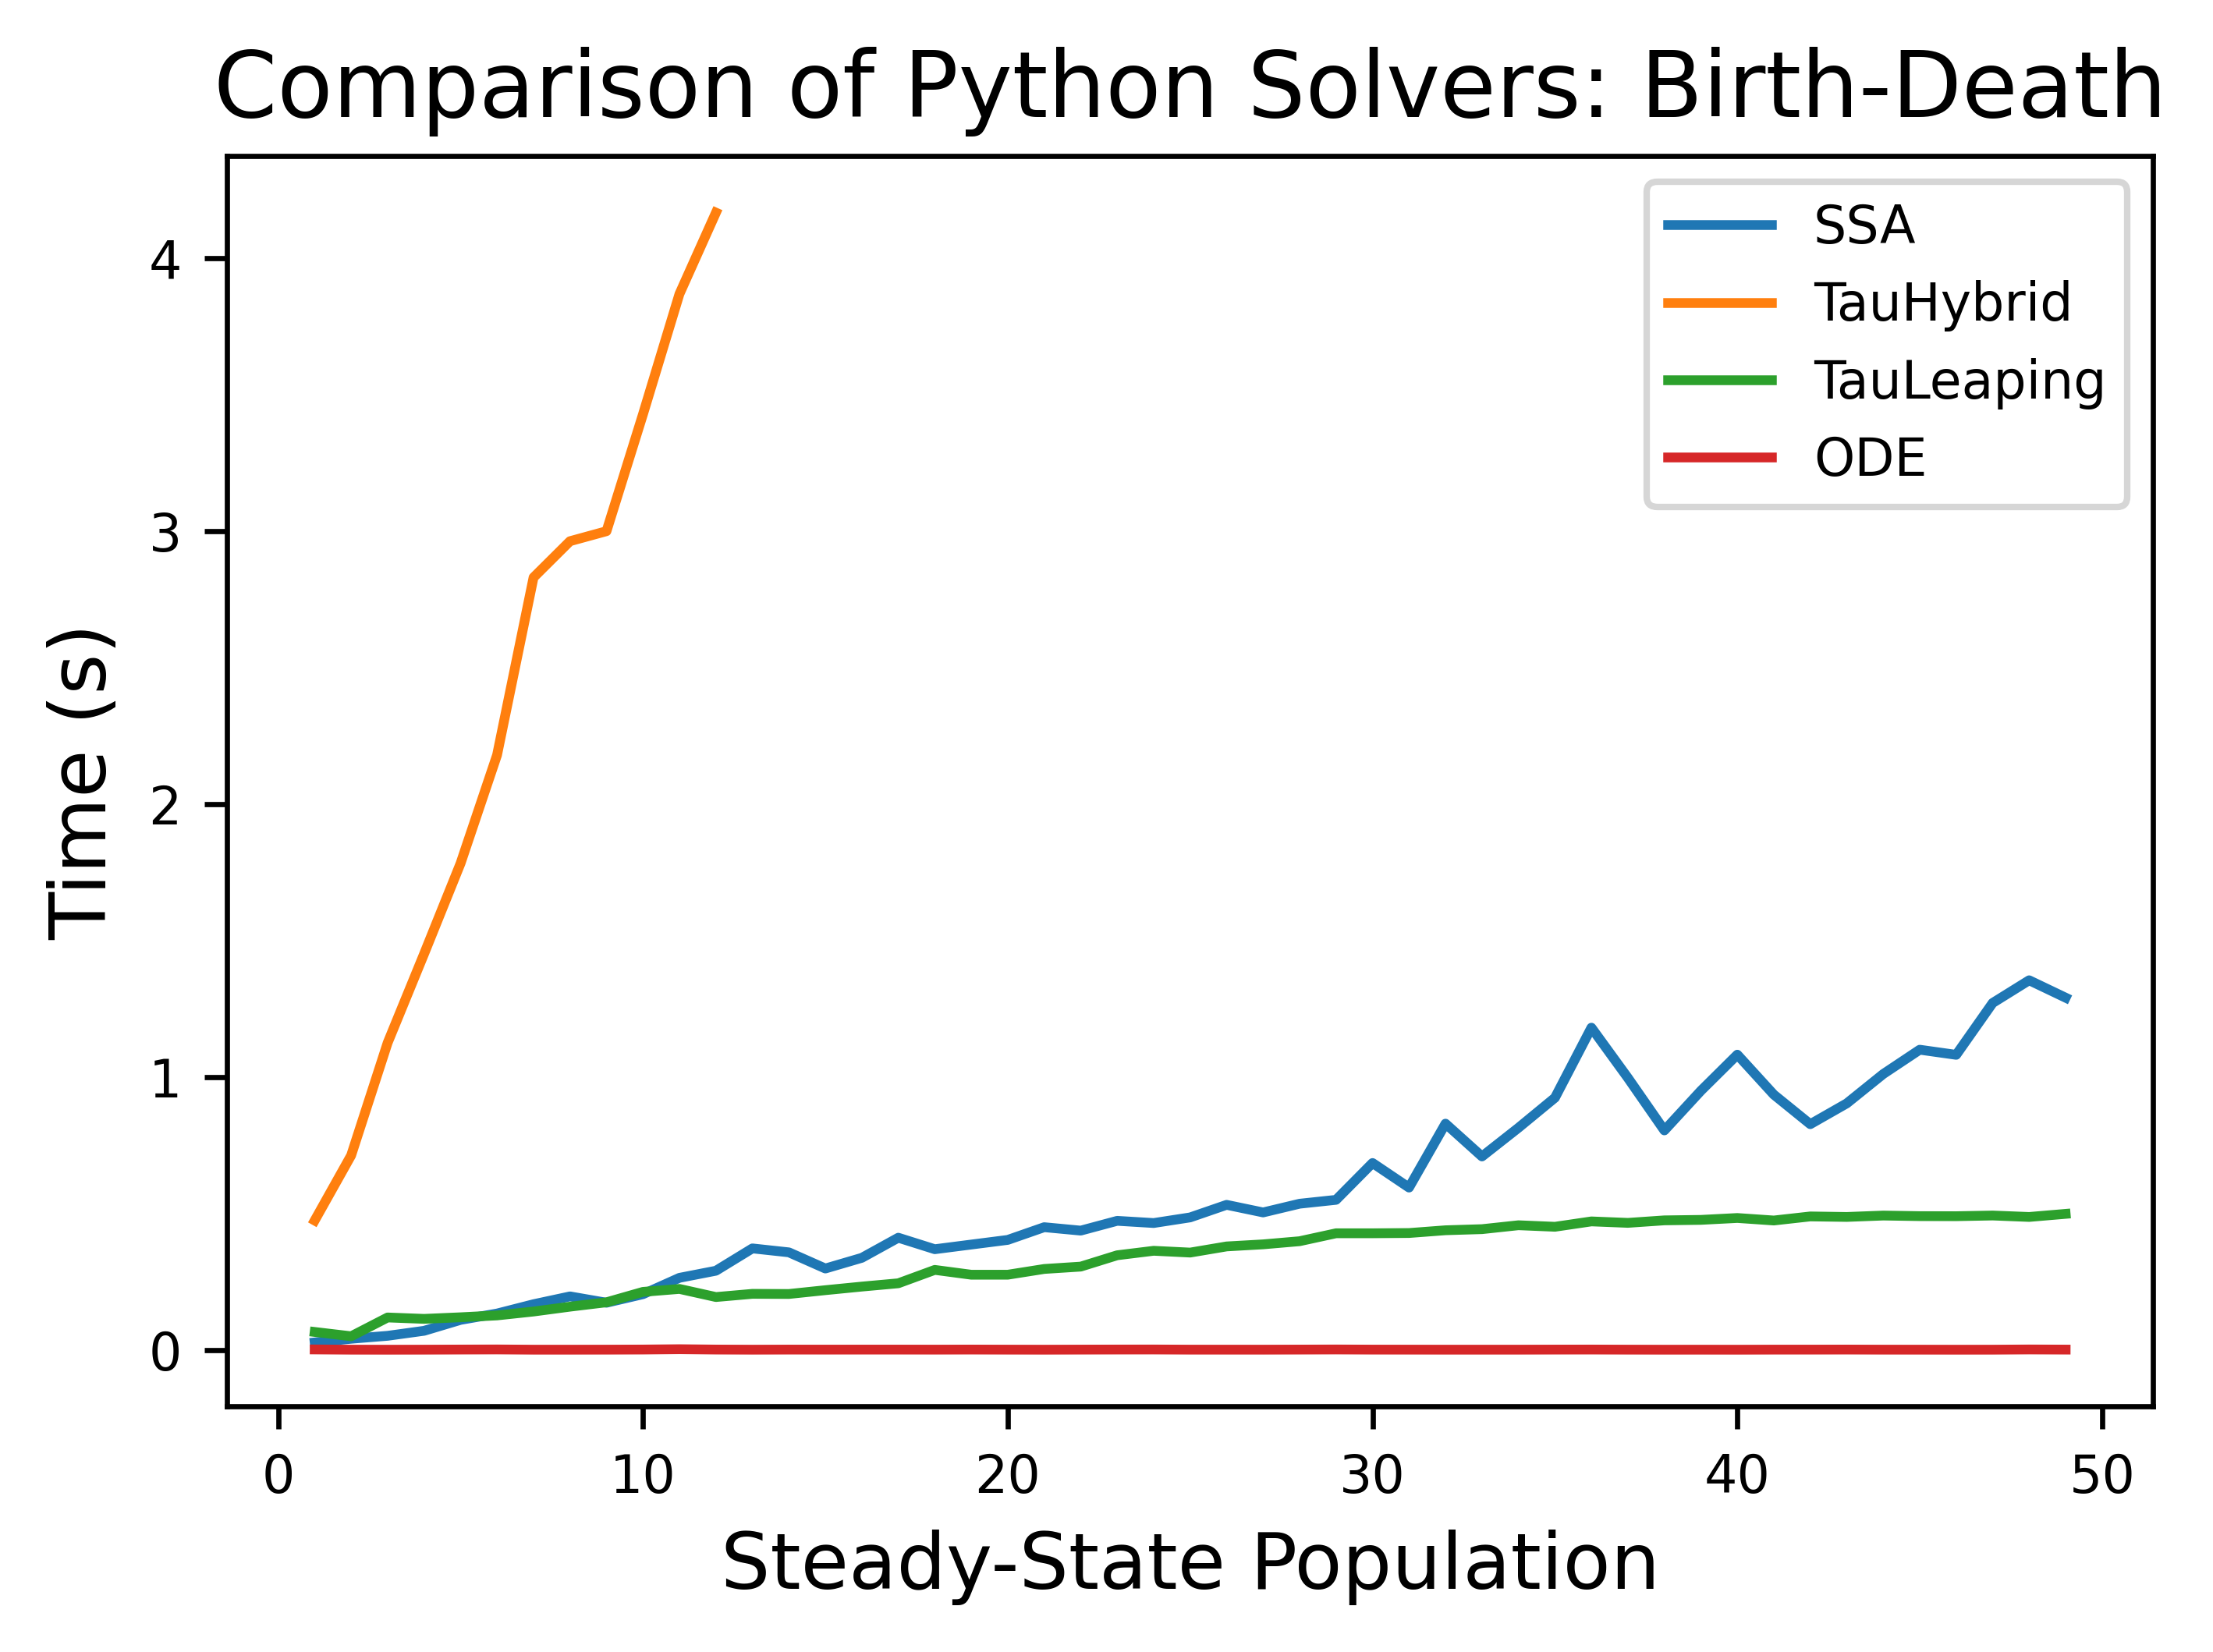

In [19]:
fig = plt.figure(figsize=(5.31,3.54), dpi=600)
for name in Solver_plot_order:
    times = C_solver_timing_data[name]
    name2=name.replace('CSolver','')
    plt.plot(v_range[0:len(NumPy_solvers_timing_data[name])], NumPy_solvers_timing_data[name], label=name2)
plt.title("Comparison of Python Solvers: Birth-Death", fontsize=14)
plt.xlabel('Steady-State Population', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Time_Comparison_Of_Python_Solvers.pdf', bbox_inches='tight')

In [20]:
raise Exception('stop')

Exception: stop

### SSA

In [ ]:
%time timing_data['SSA'] = run_test("SSA")

### Tau Leaping

In [ ]:
%time timing_data['tau_leaping'] = run_test("Tau-Leaping")

### Tau Hybrid

In [ ]:
%time timing_data['hybrid_tau'] = run_test("Tau-Hybrid")

***
## Visualizations
***

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Time Comparison of Solvers")
plt.xlabel("initial Value of V (species count)")
plt.ylabel("Simulation Run Time (s)")
plt.plot(v_range, timing_data['SSA'], label='SSA')
plt.plot(v_range, timing_data['tau_leaping'], label='tau_leaping')
plt.plot(v_range, timing_data['hybrid_tau'], label='hybrid_tau')
plt.legend(loc='best')
#plt.savefig("Time_Comparison_Of_Solvers.pdf")